In [66]:
import os
import glob
import xml.etree.ElementTree as ET


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import RoIAlign
from torchvision import transforms
from ultralytics import YOLO

import random
import numpy as np
from pathlib import Path
import cv2

In [67]:
import torch
import torch.nn as nn

class VisionAttentionLayer(nn.Module):
    """
    A standard Multi-Head Self-Attention layer for vision tasks.
    This layer is a core component of Vision Transformers (ViT).

    Args:
        dim (int): The embedding dimension of the input tokens.
        heads (int): The number of attention heads.
        dim_head (int, optional): The dimension of each attention head.
                                  Defaults to dim // heads.
        dropout (float, optional): Dropout rate. Defaults to 0.0.
    """
    def __init__(self, dim: int, heads: int = 8, dim_head: int = 64, dropout: float = 0.0):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        # The scale factor is a crucial detail for stabilizing training.
        # It's the inverse square root of the head dimension.
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x input shape: (batch_size, num_patches, dim)

        # 1. Project input to Q, K, V
        # Shape: (batch_size, num_patches, inner_dim * 3)
        qkv = self.to_qkv(x).chunk(3, dim=-1)

        # 2. Reshape Q, K, V for multi-head attention
        # Change shape to: (batch_size, heads, num_patches, dim_head)
        q, k, v = map(
            lambda t: t.reshape(t.shape[0], t.shape[1], self.heads, -1).permute(0, 2, 1, 3),
            qkv
        )

        # 3. Calculate scaled dot-product attention scores
        # (q @ k.transpose) -> (b, h, n, d) @ (b, h, d, n) -> (b, h, n, n)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # 4. Apply softmax to get attention weights
        attn_weights = self.softmax(dots)
        attn_weights = self.dropout(attn_weights)

        # 5. Apply attention weights to V (values)
        # (attn_weights @ v) -> (b, h, n, n) @ (b, h, n, d) -> (b, h, n, d)
        attended_values = torch.matmul(attn_weights, v)

        # 6. Concatenate heads and project output
        # First, reshape to (b, n, h*d) where h*d = inner_dim
        out = attended_values.permute(0, 2, 1, 3).reshape(x.shape[0], x.shape[1], -1)

        # Finally, project back to the original embedding dimension `dim`
        return self.to_out(out)

In [68]:
class ReIDAtten_v2(nn.Module):
    '''
    ReID Atten v2
    Reduced backbone of YOLOv11 
    Uses Attention Layer for head.
    157,024 parameters. 
    '''
    def __init__(self, yolo_weights='yolo11n.pt', emb_dim=128):
        super().__init__()

        yolo_model = YOLO(yolo_weights)
        self.backbone = nn.Sequential(*yolo_model.model.model[:5])
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.max_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.backbone_output_dim = self._get_feat_dim()
        # Caveat : dim = dim_head = heads
        self.attn = VisionAttentionLayer(
            dim=self.backbone_output_dim, 
            heads=4, 
            dim_head=self.backbone_output_dim // 4)
        self.embed = nn.Linear(self.backbone_output_dim, emb_dim)

    def _get_feat_dim(self):
        x = torch.zeros((1, 3, 256, 128))
        with torch.no_grad():
            x = self.backbone(x)
            return x.shape[1]  # fix here
    def forward(self, x):
        x = self.backbone(x)          # (B, C, H, W)


        flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        # print("input to atten:", flat.shape)
        att = self.attn(flat)              # (B, H*W, C)
        # print(att.shape)
        att = att.mean(dim=1) 
        # print(att.shape)            # (B, C)
        embed = self.embed(att)             # (B, 128)
        return nn.functional.normalize(embed, dim=1)

In [69]:




device = torch.device("cpu")

# base_dir = os.path.dirname(os.path.abspath(__file__))
model = ReIDAtten_v2()
model.eval()
model.load_state_dict(torch.load("ReIDAttenv2_6000.pth",map_location=torch.device('cpu')))

dummy = torch.randn(2,3,256,128)
out = model(dummy)  # shape: (2,128,16,8)
print(out.shape)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)


torch.Size([2, 128])
157024


In [70]:
import torch

# model = YourModelClass().eval()
# model.load_state_dict(torch.load("model.pth"))

dummy_input = torch.randn(1,3,256,128)  # adjust shape
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=["input"], output_names=["output"],
                  opset_version=11)

In [74]:
!ovc model.onnx --compress_to_fp16=False

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\USER\anaconda3\envs\dashboard_v2\Scripts\ovc.exe\__main__.py", line 7, in <module>
  File "C:\Users\USER\anaconda3\envs\dashboard_v2\Lib\site-packages\openvino\tools\ovc\main.py", line 32, in main
    save_model(ngraph_function, model_path.encode('utf-8'), compress_to_fp16)
RuntimeError: Check 'bin_file' failed at src\core\src\pass\serialize.cpp:1272:
Can't open bin file.



In [32]:
from openvino.runtime import Core


core = Core()
model_opt_read = core.read_model("model.xml")
compiled_model = core.compile_model(model_opt_read, "CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)


model = ReIDAtten_v2()
model.eval()
model.load_state_dict(torch.load("ReIDAttenv2_6000.pth",map_location=torch.device('cpu')))


<All keys matched successfully>

In [34]:
dummy_np = np.random.rand(1, 3, 256, 128).astype(np.float32)
# dummy_input = torch.randn(1,3,256,128) 
dummy_tensor = torch.from_numpy(dummy_np).to(device)

import time
# -------- Benchmark PyTorch --------
with torch.no_grad():
    torch_times = []
    for _ in range(100):
        start = time.time()
        _ = model(dummy_tensor)
        torch_times.append(time.time() - start)
torch_avg = np.mean(torch_times)

# -------- Benchmark OpenVINO --------
ov_times = []
for _ in range(100):
    start = time.time()
    _ = compiled_model([dummy_np])[output_layer]
    ov_times.append(time.time() - start)
ov_avg = np.mean(ov_times)

In [50]:
print(f"Torch model\t: {torch_avg*1000} ms")
print(f"OpenVINO model  : {ov_avg*1000} ms")
print(f"{100 * torch_avg/ov_avg:.2f} % Faster")

Torch model	: 9.29511547088623 ms
OpenVINO model  : 2.721703052520752 ms
341.52 % Faster


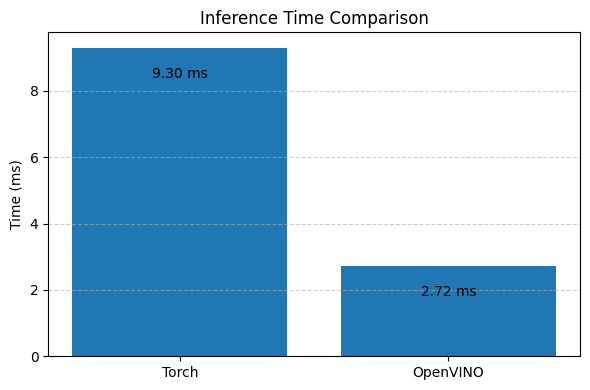

In [57]:
import matplotlib.pyplot as plt

# Inference times in milliseconds
models = ['Torch', 'OpenVINO']
times = [torch_avg * 1000, ov_avg * 1000]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, times)

# Add labels
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() -1,
             f"{t:.2f} ms", ha='center', va='bottom', fontsize=10)

plt.title("Inference Time Comparison")
plt.ylabel("Time (ms)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("opt_comparison.png", dpi=300)
plt.show()

In [60]:
YOLO('yolov8n.pt').export(format='openvino', dynamic=False, half=False)

Ultralytics 8.3.170  Python-3.11.13 torch-2.7.1+cpu CPU (13th Gen Intel Core(TM) i5-1335U)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success  1.9s, saved as 'yolov8n_openvino_model\' (12.3 MB)

Export complete (2.2s)
Results saved to D:\Dropbox\LEARN\vision_project1\reidentification_project\model_construct_ipy\optimization
Predict:         yolo predict task=detect model=yolov8n_openvino_model imgsz=640  
Validate:        yolo val task=detect model=yolov8n_openvino_model imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n_openvino_model'